In [2]:
from matplotlib import pyplot as plt

import numpy as np
np.random.seed(42)
import random
random.seed(42)

In [3]:
from sklearn.datasets import fetch_20newsgroups
categories = ['comp.graphics', 'comp.os.ms-windows.misc',
'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
'rec.autos', 'rec.motorcycles',
'rec.sport.baseball', 'rec.sport.hockey']
train_dataset = fetch_20newsgroups(subset = 'train', categories = categories
, shuffle = True, random_state = 42)
test_dataset = fetch_20newsgroups(subset = 'test', categories = categories
, shuffle = True, random_state = 42)

(array([584.,   0., 591.,   0.,   0., 590.,   0.,   0., 578.,   0.,   0.,
        594.,   0.,   0., 598.,   0.,   0., 597.,   0., 600.]),
 array([0.  , 0.35, 0.7 , 1.05, 1.4 , 1.75, 2.1 , 2.45, 2.8 , 3.15, 3.5 ,
        3.85, 4.2 , 4.55, 4.9 , 5.25, 5.6 , 5.95, 6.3 , 6.65, 7.  ]),
 <a list of 20 Patch objects>)

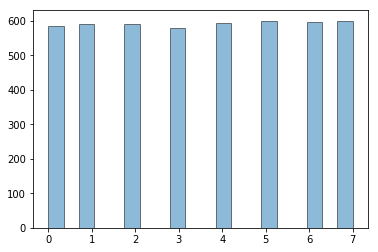

In [4]:
from matplotlib import pyplot as plt
import numpy as np
plt.hist(train_dataset.target,bins=20, alpha=0.5, histtype='bar', ec='black',
        label=categories)

In [5]:
import nltk
from nltk import pos_tag
# nltk.download('punkt')#, if you need "tokenizers/punkt/english.pickle", choose it
# nltk.download('averaged_perceptron_tagger')

wnl = nltk.wordnet.WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

def lemmatize_sent(list_word):
    # Text input is string, returns array of lowercased strings(words).
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(list_word)]

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

def stem_rmv_punc(doc):
    return (word for word in lemmatize_sent(analyzer(doc)) if not word.isdigit())

In [7]:
vectorizer = CountVectorizer(min_df=3, 
                             analyzer=stem_rmv_punc, 
                             stop_words='english')

# fit_tranform train data
X_train_counts = vectorizer.fit_transform(train_dataset.data)
print("train count size ", X_train_counts.shape)


X_test_counts = vectorizer.transform(test_dataset.data)
print("test count size ", X_test_counts.shape)

# vectorizer.get_feature_names()

train count size  (4732, 16600)
test count size  (3150, 16600)


In [8]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()

# fit_tranform train data
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
#print(X_train_tfidf.shape)
#print('-' * 20)
#print(X_train_counts.toarray()[:10,:5])
#print('-' * 20)
#print(X_train_tfidf.toarray()[:10,:5])

# transform test data
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
#print(X_test_tfidf.shape)
#print('-' * 20)
#print(X_test_counts.toarray()[:10,:5])
#print('-' * 20)
#print(X_test_tfidf.toarray()[:10,:5])

In [9]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=50, random_state=42)
X_train_reduced = svd.fit_transform(X_train_tfidf)
print(X_train_reduced.shape)

(4732, 50)


## Question 6

### Naive Bayes with GaussianNB

#### Classify the documents into two classes

In [10]:
_, idx = np.unique(train_dataset.target, return_index=True)
for i in range(len(idx)):
    j = np.sort(idx)[i]
    print(train_dataset.target_names[i],': target index = ', train_dataset.target[j])

#print(train_dataset.target[15:25])
#print(train_dataset.target_names[15:25])

comp.graphics : target index =  6
comp.os.ms-windows.misc : target index =  7
comp.sys.ibm.pc.hardware : target index =  4
comp.sys.mac.hardware : target index =  2
rec.autos : target index =  1
rec.motorcycles : target index =  3
rec.sport.baseball : target index =  0
rec.sport.hockey : target index =  5


In [11]:
train_dataset.bintarget = np.zeros_like(train_dataset.target)
test_dataset.bintarget = np.zeros_like(test_dataset.target)
for y in [6, 7, 4, 2]:
    train_dataset.bintarget[np.argwhere(train_dataset.target == y)] = 0
    test_dataset.bintarget[np.argwhere(test_dataset.target == y)] = 0
for y in [1, 3, 0, 5]:
    train_dataset.bintarget[np.argwhere(train_dataset.target == y)] = 1
    test_dataset.bintarget[np.argwhere(test_dataset.target == y)] = 1
class_names = ['Computer Technology', 'Recreational Activity']
#print(train_dataset.bintarget[:20])

#### Train GaussianNB

In [12]:
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import GaussianNB

from sklearn.base import BaseEstimator, TransformerMixin
class SparseToDenseArray(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def transform(self, X, *_):
        if hasattr(X, 'toarray'):
            return X.toarray()
        return X

    def fit(self, *_):
        return self

from sklearn.decomposition import TruncatedSVD, NMF

# nmf = NMF(n_components=50, init='random', random_state=42)

# "The purpose of the pipeline is to assemble several steps that can 
#  be cross-validated together while setting different parameters."
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('vect', vectorizer),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=50, random_state=42)),
    ('toarr', SparseToDenseArray()),
    ('clf', GaussianNB()),
])



In [13]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
def plot_roc(fpr, tpr):
    fig, ax = plt.subplots()

    roc_auc = auc(fpr,tpr)

    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)

    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)

def fit_predict_and_plot_roc(pipe, train_data, train_label, test_data, test_label):
    pipe.fit(train_data, train_label)

    if hasattr(pipe, 'decision_function'):
        prob_score = pipe.decision_function(test_data)
        fpr, tpr, _ = roc_curve(test_label, prob_score)
    else:
        prob_score = pipe.predict_proba(test_data)
        fpr, tpr, _ = roc_curve(test_label, prob_score[:,1])

    plot_roc(fpr, tpr)
#     return pipe

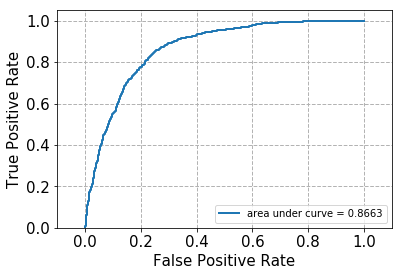

In [15]:
fit_predict_and_plot_roc(pipeline, train_dataset.data, train_dataset.bintarget, test_dataset.data, test_dataset.bintarget)

#### Confusion Matrix

In [16]:
pred = pipeline.predict(test_dataset.data)

In [17]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print('accuracy:', accuracy_score(test_dataset.bintarget, pred))
print('recall:', recall_score(test_dataset.bintarget, pred))
print('precision:', precision_score(test_dataset.bintarget, pred))
print('f1_score:', f1_score(test_dataset.bintarget, pred))

accuracy: 0.7542857142857143
recall: 0.6340996168582376
precision: 0.8316582914572864
f1_score: 0.7195652173913044


In [18]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Confusion matrix, without normalization
[[1383  201]
 [ 573  993]]
Normalized confusion matrix
[[0.87 0.13]
 [0.37 0.63]]


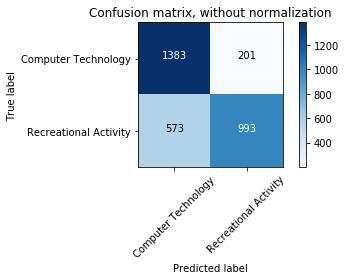

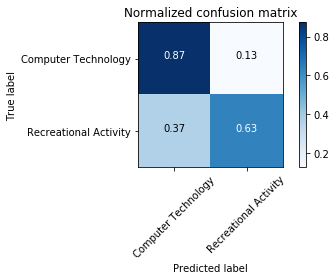

In [19]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_dataset.bintarget, pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()